# Inception_V3 model summary

In [20]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

# Build fine-tune Inception_V3 model

## Preprocessing: load image

In [21]:
import numpy as np
import time
from keras.applications.inception_v3 import InceptionV3 #CHANGE
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.layers import Dense,Activation,Flatten
from keras.layers import merge,Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import resample #CHANGE
from sklearn.cross_validation import train_test_split
import os

data_path=r"D:\semester3\capstone\FGVC_5S_5L"
data = os.listdir(data_path)

img_data_list=[]

for dataset in data:
    img_list = os.listdir(data_path+'/'+dataset)
    print('loaded images'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path+'/'+dataset+'/'+img
        img = image.load_img(img_path,target_size=(299,299))
        x = image.img_to_array(img)
        x = np.expand_dims(x,axis=0)
        x = preprocess_input(x)
        #print('Input image shape',x.shape)
        img_data_list.append(x)
        
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data,1,0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)

num_classes = 10
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')


labels[0:574] = 0
labels[574:671] =1
labels[671:1240] =2
labels[1240:1323]=3
labels[1323:1845]=4
labels[1845:1866]=5
labels[1866:1949]=6
labels[1949:1993]=7
labels[1993:2567]=8
labels[2567:3127]=9

names=['Calidris alba','Gallus gallus domesticus','Geococcyx californianus','Phoenicopterus roseus','Picoides villosus','Spheniscus demersus','Sterna striata','Struthio camelus','Thryothorus ludovicianus','Tyrannus verticalis']



loaded imagesCalidris alba

loaded imagesGallus gallus domesticus

loaded imagesGeococcyx californianus

loaded imagesPhoenicopterus roseus

loaded imagesPicoides villosus

loaded imagesSpheniscus demersus

loaded imagesSterna striata

loaded imagesStruthio camelus

loaded imagesThryothorus ludovicianus

loaded imagesTyrannus verticalis

(3127, 1, 299, 299, 3)
(1, 3127, 299, 299, 3)
(3127, 299, 299, 3)


## Preprocessing: split into train and test set 

In [22]:
Y = np_utils.to_categorical(labels,num_classes)

x,y = resample(img_data,Y,random_state=2,replace=False)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

## Fine-tune model summary

In [23]:
image_input = Input(shape=(299,299,3))
model=InceptionV3(input_tensor=image_input,weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 149, 149, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 149, 149, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

In [24]:
last_layer = model.get_layer('avg_pool').output
out =Dense(num_classes,activation='softmax',name='output')(last_layer)
custom_InceptionV3_model = Model(image_input,out)
custom_InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 149, 149, 32) 96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 149, 149, 32) 0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

# Train the fine-tune Inception_V3 model

In [ ]:
for layer in custom_InceptionV3_model.layers[:-1]:
    layer.trainable = False
    
print(custom_InceptionV3_model.layers[3].trainable)

custom_InceptionV3_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

t=time.time()
hist=custom_InceptionV3_model.fit(X_train,y_train,batch_size=32,epochs=5,verbose=1,validation_data=(X_test,y_test))
print('Taining time:%s' %(t-time.time()))
(loss,accuracy)=custom_InceptionV3_model.evaluate(X_test,y_test,batch_size=10,verbose=1)
print('loss={:.4f},accuracy:{:.4f}%'.format(loss,accuracy*100))

# Predict the fine-tune Inception_V3 model

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

In [27]:
Y_pred=custom_InceptionV3_model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)

## Classification report

In [28]:
target_names=['Calidris alba','Gallus gallus domesticus','Geococcyx californianus','Phoenicopterus roseus','Picoides villosus','Spheniscus demersus','Sterna striata','Struthio camelus','Thryothorus ludovicianus','Tyrannus verticalis']
print(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names))

                          precision    recall  f1-score   support

           Calidris alba       0.32      0.14      0.20       125
Gallus gallus domesticus       0.00      0.00      0.00        18
 Geococcyx californianus       0.54      0.43      0.48       116
   Phoenicopterus roseus       0.00      0.00      0.00        11
       Picoides villosus       0.33      0.01      0.02       104
     Spheniscus demersus       0.00      0.00      0.00         8
          Sterna striata       0.00      0.00      0.00        15
        Struthio camelus       0.00      0.00      0.00         8
Thryothorus ludovicianus       0.16      0.46      0.24       108
     Tyrannus verticalis       0.06      0.08      0.07       113

             avg / total       0.26      0.20      0.19       626



C:\Users\Zhouxianwei\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Plot confusion matrix

In [29]:
cm=confusion_matrix(np.argmax(y_test,axis=1),y_pred)

In [30]:
import matplotlib.pyplot as plt
import itertools

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18  0  1  0  1  0  5  0 19 81]
 [ 0  0  8  0  0  0  0  0  9  1]
 [15  0 50  0  0  0  2  0 43  6]
 [ 0  0  0  0  0  0  0  0  7  4]
 [10  0 18  0  1  0  1  0 67  7]
 [ 1  0  0  0  0  0  0  0  7  0]
 [ 1  0  0  0  0  0  0  0 11  3]
 [ 2  0  2  0  0  0  0  0  0  4]
 [ 4  0 10  0  1  0  1  0 50 42]
 [ 5  0  3  0  0  0  0  0 96  9]]


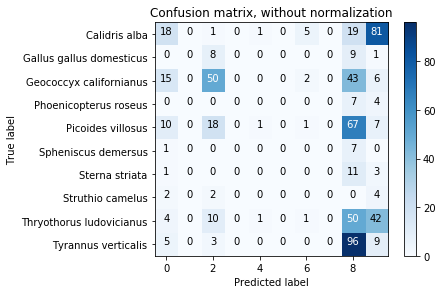

In [32]:
plt.figure()
plot_confusion_matrix(cm, classes=target_names,title='Confusion matrix, without normalization')
plt.show()